https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters

In [1]:
import numpy as np
import numpy.linalg as la
import sympy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
DEG_TO_RAD = sp.pi / 180

This box has the math that matters.

* I'd like the students to be given formulas, but not code. They should get actual first-hand experience with sympy.
* You should give them check functionality to make sure their forward kinematics compute the same result as backward.
* Objective function is the norm of the difference between manipulator tip and desired position
* Manipulator tip position is the last column of the matrix, in [homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)
* Steepest descent and Gauss-Newton should both work. Perhaps have them compare?
* You should come up with at least three more manipulator designs and randomize between them

In [20]:
def translation_mat(vec):
    result = sp.eye(4)
    result[:3, -1] = vec
    return result

def rotation_mat(i, j, angle):
    result = sp.eye(4)
    assert i < j
    result[i, i] = sp.cos(angle)
    result[j, j] = sp.cos(angle)
    result[i, j] = -sp.sin(angle)
    result[j, i] = sp.sin(angle)
    return result

class Link:
    def __init__(self, angle, offset, twist, length):
        self.angle = angle
        self.offset = offset
        self.twist = twist
        self.length = length

def link_rot_mat(link):
    return rotation_mat(0, 1, link.angle)

def link_mat(link):
    return link_rot_mat(link) @ translation_mat([0, 0, link.offset])

def joint_rot_mat(link):
    return rotation_mat(1, 2, link.twist)

def joint_mat(link):
    return joint_rot_mat(link) @ translation_mat([link.length, 0 , 0])

def denavit_hartenberg_mat(link):
    return link_mat(link) @ joint_mat(link)

def chain_matrix(chain):
    result = sp.eye(4)
    for link in chain:
        result = result @ denavit_hartenberg_mat(link)
    return result
        

This next bit is just visualization. You can let the students use this unchanged.

In [18]:
def draw_tube(ax, mat, height, radius):
    if abs(height) < 1e-5:
        return

    nanglepts = 10
    nheightpts = 2
    heights = np.linspace(0, height, nheightpts)
    angles = np.linspace(0, 2*np.pi, nanglepts)
    x = np.cos(angles)*radius
    y = np.sin(angles)*radius
    
    vectors = np.zeros((4, nanglepts, nheightpts))
    vectors[0] = x.reshape(-1, 1)
    vectors[1] = y.reshape(-1, 1)
    vectors[2] = heights
    vectors[3] = 1

    vectors = np.einsum("ik,kjl->ijl", mat, vectors)

    ax.plot_surface(vectors[0], vectors[1], vectors[2])

def swap_mat(ax1, ax2):
    result = np.eye(4)
    result[ax1] = 0
    result[ax2] = 0
    result[ax1, ax2] = 1
    result[ax2, ax1] = 1
    return result

def draw_chain(ax, chain, var_values, radius=None, initial_mat=None):
    if radius is None:
        radius = 0.1

    def ev(val):
        return float(sp.sympify(val).subs(var_values))

    def evmat(m):
        return np.array(m.subs(var_values)).astype(np.float64)
    
    
    if initial_mat is None:
        mat = np.eye(4)
    else:
        mat = initial_mat.copy()

    for link in chain:
        omat = mat @ evmat(link_rot_mat(link))
        draw_tube(ax, omat, height=ev(link.offset), radius=radius)
        mat = mat @ evmat(link_mat(link))

        omat = mat @ evmat(joint_rot_mat(link)) @ swap_mat(0, 2)
        draw_tube(ax, omat, height=ev(link.length), radius=radius)
        mat = mat @ evmat(joint_mat(link))

def show_chain_views(chain, var_values, radius=None):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121, projection='3d')

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("z")

    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_zlim([0, 5])
    
    draw_chain(ax1, chain, var_values, radius)
    
    ax2 = fig.add_subplot(122, projection='3d')

    ax2.set_xlabel("y")
    ax2.set_ylabel("x")
    ax2.set_zlabel("z")

    ax2.set_xlim([-3, 3])
    ax2.set_ylim([-3, 3])
    ax2.set_zlim([0, 5])
    
    draw_chain(ax2, chain, var_values, radius, initial_mat=swap_mat(0, 1))


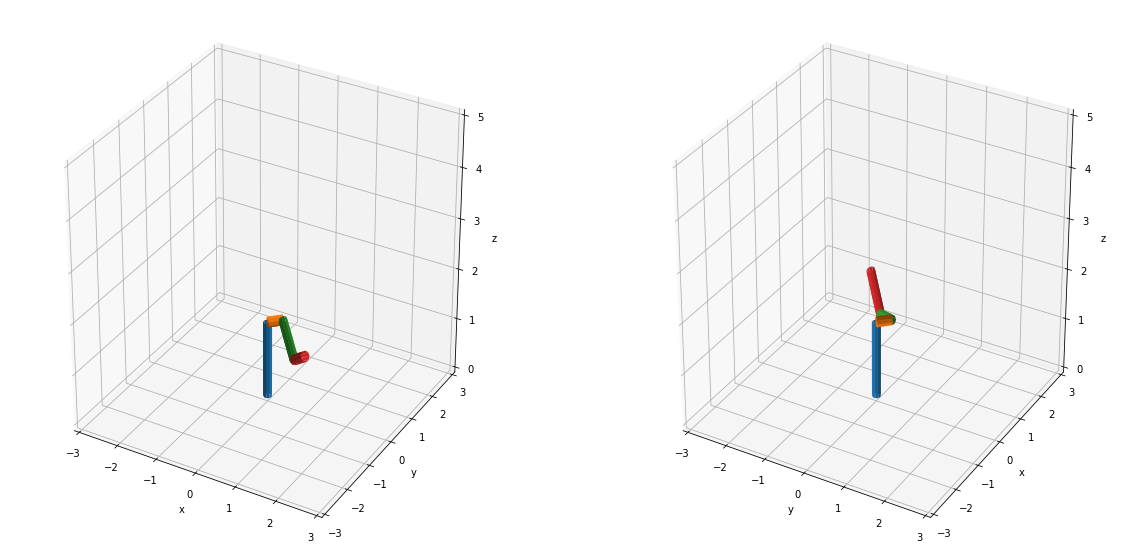

In [71]:
three_dof_chain = [
    Link(
      angle=sp.Symbol("torso_rot"),
      offset=1.5,
      twist=90*DEG_TO_RAD + sp.Symbol("shoulder_rot"),
      length=0.35,
    ),        
    Link(
      angle=0*DEG_TO_RAD,
      offset=1,
      twist=sp.Symbol("elbow_rot"),
      length=0,
    ),        
    Link(
      angle=0,
      offset=1,
      twist=0*DEG_TO_RAD,
      length=0,
    ),        
]

show_chain_views(three_dof_chain, {"torso_rot": 45*DEG_TO_RAD, "shoulder_rot": 20*DEG_TO_RAD, "elbow_rot": -50*DEG_TO_RAD})

In [72]:
chain_matrix(three_dof_chain)

# position is in last column

Matrix([
[cos(torso_rot),  sin(elbow_rot)*sin(torso_rot)*cos(shoulder_rot) + sin(shoulder_rot)*sin(torso_rot)*cos(elbow_rot), -sin(elbow_rot)*sin(shoulder_rot)*sin(torso_rot) + sin(torso_rot)*cos(elbow_rot)*cos(shoulder_rot), -sin(elbow_rot)*sin(shoulder_rot)*sin(torso_rot) + sin(torso_rot)*cos(elbow_rot)*cos(shoulder_rot) + sin(torso_rot)*cos(shoulder_rot) + 0.35*cos(torso_rot)],
[sin(torso_rot), -sin(elbow_rot)*cos(shoulder_rot)*cos(torso_rot) - sin(shoulder_rot)*cos(elbow_rot)*cos(torso_rot),  sin(elbow_rot)*sin(shoulder_rot)*cos(torso_rot) - cos(elbow_rot)*cos(shoulder_rot)*cos(torso_rot),  sin(elbow_rot)*sin(shoulder_rot)*cos(torso_rot) + 0.35*sin(torso_rot) - cos(elbow_rot)*cos(shoulder_rot)*cos(torso_rot) - cos(shoulder_rot)*cos(torso_rot)],
[             0,                               -sin(elbow_rot)*sin(shoulder_rot) + cos(elbow_rot)*cos(shoulder_rot),                               -sin(elbow_rot)*cos(shoulder_rot) - sin(shoulder_rot)*cos(elbow_rot),                         

In [60]:
chain_matrix(three_dof_chain).diff("torso_rot")

Matrix([
[-sin(torso_rot), sin(elbow_rot)*cos(shoulder_rot)*cos(torso_rot) + sin(shoulder_rot)*cos(elbow_rot)*cos(torso_rot), -sin(elbow_rot)*sin(shoulder_rot)*cos(torso_rot) + cos(elbow_rot)*cos(shoulder_rot)*cos(torso_rot), -sin(elbow_rot)*sin(shoulder_rot)*cos(torso_rot) - 0.75*sin(torso_rot) + cos(elbow_rot)*cos(shoulder_rot)*cos(torso_rot) + cos(shoulder_rot)*cos(torso_rot)],
[ cos(torso_rot), sin(elbow_rot)*sin(torso_rot)*cos(shoulder_rot) + sin(shoulder_rot)*sin(torso_rot)*cos(elbow_rot), -sin(elbow_rot)*sin(shoulder_rot)*sin(torso_rot) + sin(torso_rot)*cos(elbow_rot)*cos(shoulder_rot), -sin(elbow_rot)*sin(shoulder_rot)*sin(torso_rot) + sin(torso_rot)*cos(elbow_rot)*cos(shoulder_rot) + sin(torso_rot)*cos(shoulder_rot) + 0.75*cos(torso_rot)],
[              0,                                                                                                 0,                                                                                                  0,                         

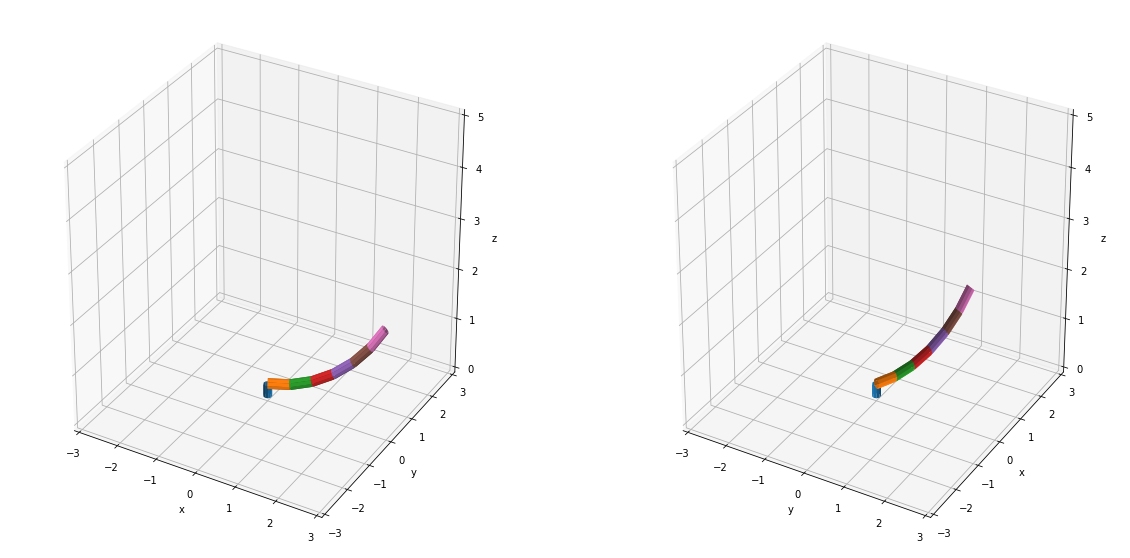

In [70]:
snake_chain = [
    Link(
      angle=sp.Symbol("torso_rot"),
      offset=.25,
      twist=90*DEG_TO_RAD,
      length=0.5,
    ),        
] + [Link(
      angle=sp.Symbol(f"j{i}"),
      offset=0,
      twist=0,
      length=0.5,
    )
    for i in range(5)]
    


show_chain_views(snake_chain, {
    "torso_rot": 25*DEG_TO_RAD,
    "j0": 10*DEG_TO_RAD,
    "j1": 10*DEG_TO_RAD,
    "j2": 10*DEG_TO_RAD,
    "j3": 10*DEG_TO_RAD,
    "j4": 10*DEG_TO_RAD,
})